In [1]:
# by Joh Schöneberg 2018

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

# input data

In [3]:
inputParameters = pd.read_csv('../../input/_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))




In [4]:
# read the raw csv data for further processing

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]





/Users/johannesschoeneberg/git/pyLattice/input/big_data_cutoff7000/output/trackedFeaturesProcessed.csv


,trackId,tracklength,time[s],frameId,lifetime,catIdx,m_x,m_y,m_z,m_A,m_c,m_pval_Ar,s_x,s_y,s_z,s_A,s_c,s_pval_Ar
0,1,70,0,1,398.23,4,3.062726e+02,4.632271e+02,1.562220e+02,1.739935e+04,4.432718e+03,0,3.056966e+02,4.635165e+02,1.562220e+02,1.686132e+04,1.297400e+04,2.908224e-107
1,1,70,5.689000e+00,2,398.23,4,3.057494e+02,4.640244e+02,1.565502e+02,1.750579e+04,5.094934e+03,0,3.055449e+02,4.652281e+02,1.565502e+02,2.257769e+04,1.144006e+04,4.655316e-239
2,1,70,1.137800e+01,3,398.23,4,3.057335e+02,4.664979e+02,1.568321e+02,1.813164e+04,3.976445e+03,0,3.059583e+02,4.666809e+02,1.568321e+02,1.997363e+04,1.044525e+04,1.311695e-167
3,1,70,1.706700e+01,4,398.23,4,3.058162e+02,4.672333e+02,1.563690e+02,1.982398e+04,3.983064e+03,0,3.048128e+02,4.671221e+02,1.563690e+02,3.260338e+04,1.168456e+04,0
4,1,70,2.275600e+01,5,398.23,4,3.056440e+02,4.680644e+02,1.574940e+02,1.536418e+04,3.799193e+03,0,3.049258e+02,4.689656e+02,1.574940e+02,1.774456e+04,1.042424e+04,3.282493e-179


# gather statistics

[6312, 4, 2276, 8, 87, 0, 124, 2]
[ 0.  0.  0.  0.  0.  0.  0.  0.]


Text(0.5,1,'N = 8813')

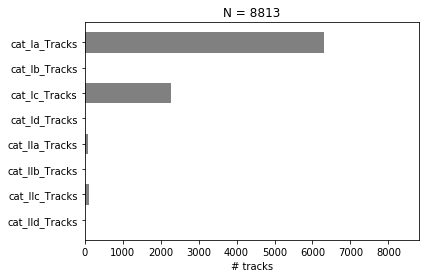

In [5]:
#plot them all

#%----------------------------------------------------------------------------
#    % I. Assign category to each track
#    %----------------------------------------------------------------------------
#    % Categories:
#    % Ia)  Single tracks with valid gaps
#    % Ib)  Single tracks with invalid gaps
#    % Ic)  Single tracks cut at beginning or end
#    % Id)  Single tracks, persistent
#    % IIa) Compound tracks with valid gaps
#    % IIb) Compound tracks with invalid gaps
#    % IIc) Compound tracks cut at beginning or end
#    % IId) Compound tracks, persistent
#    
#    % The categories correspond to index 1-8, in the above order



#data = longtracks
data = data

allTracks = np.unique(data['trackId'].values)
cat_Ia_Tracks = np.unique(data[data['catIdx'] == 1]['trackId'])
cat_Ib_Tracks = np.unique(data[data['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(data[data['catIdx'] == 3]['trackId'])
cat_Id_Tracks = np.unique(data[data['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(data[data['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(data[data['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(data[data['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(data[data['catIdx'] == 8]['trackId'])

categories = [cat_Ia_Tracks,cat_Ib_Tracks,cat_Ic_Tracks,cat_Id_Tracks,cat_IIa_Tracks,cat_IIb_Tracks,cat_IIc_Tracks,cat_IId_Tracks]
categoryLabels = ["cat_Ia_Tracks","cat_Ib_Tracks","cat_Ic_Tracks","cat_Id_Tracks","cat_IIa_Tracks","cat_IIb_Tracks","cat_IIc_Tracks","cat_IId_Tracks"]

categoryFrequency = []
for cat in categories:
    categoryFrequency.append(len(cat))
    
print(categoryFrequency)



# https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(categoryFrequency))

error = np.random.rand(len(categoryFrequency))
error = np.zeros(len(categoryFrequency))
print(error)

ax.barh(y_pos, categoryFrequency, xerr=error, align='center',
        color='grey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(categoryLabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# tracks')
ax.set_xlim(0,len(allTracks))
ax.set_title('N = '+str(len(allTracks)))

In [167]:
cat_Ia_Tracks = data[data['catIdx'] == 1]
cat_Ib_Tracks = data[data['catIdx'] == 2]
cat_Ic_Tracks = data[data['catIdx'] == 3]
cat_Id_Tracks = data[data['catIdx'] == 4]
cat_IIa_Tracks = data[data['catIdx'] == 5]
cat_IIb_Tracks = data[data['catIdx'] == 6]
cat_IIc_Tracks = data[data['catIdx'] == 7]
cat_IId_Tracks = data[data['catIdx'] == 8]

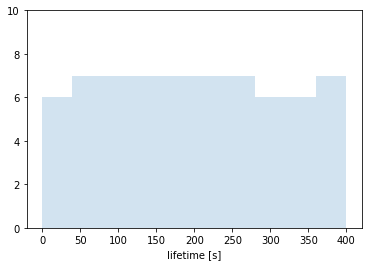

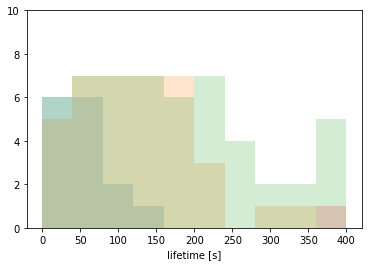

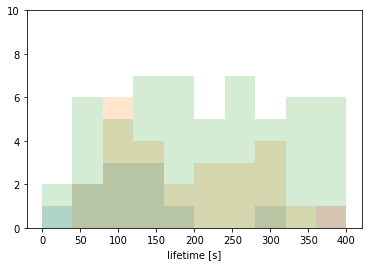

In [168]:
allTracks_lifetime = np.unique(data['lifetime'].values)

cat_Ia_Tracks_lifetime = np.unique(data[data['catIdx'] == 1]['lifetime'])
cat_Ib_Tracks_lifetime = np.unique(data[data['catIdx'] == 2]['lifetime'])
cat_Ic_Tracks_lifetime = np.unique(data[data['catIdx'] == 3]['lifetime'])
cat_Id_Tracks_lifetime = np.unique(data[data['catIdx'] == 4]['lifetime'])
cat_IIa_Tracks_lifetime = np.unique(data[data['catIdx'] == 5]['lifetime'])
cat_IIb_Tracks_lifetime = np.unique(data[data['catIdx'] == 6]['lifetime'])
cat_IIc_Tracks_lifetime = np.unique(data[data['catIdx'] == 7]['lifetime'])
cat_IId_Tracks_lifetime = np.unique(data[data['catIdx'] == 8]['lifetime'])
bins_ = 10
range_ = [0,400]
plt.hist(allTracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.ylim(0,10)
plt.xlabel('lifetime [s]')
plt.show()
plt.hist(cat_Ia_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.hist(cat_Ib_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.hist(cat_Ic_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.hist(cat_Id_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.ylim(0,10)
plt.xlabel('lifetime [s]')
plt.show()
plt.hist(cat_IIa_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.hist(cat_IIb_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.hist(cat_IIc_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.hist(cat_IId_Tracks_lifetime,alpha=0.2,bins=bins_,range=range_)
plt.ylim(0,10)
plt.xlabel('lifetime [s]')
plt.show()

In [ ]:
#Lifetime Cohorts

In [ ]:
lifetimeCohort = np.unique(data[data['lifetime'] >= 1 and data['lifetime'] <=20])

In [136]:
lifetimeThresholds = [1, 20, 40, 60, 80, 100, 120, 200]

lifetimeCohorts = []

dataBasis = cat_Ia_Tracks
for i in range(2,len(lifetimeThresholds)):
    lifetimeCohort_trackIds = np.unique(dataBasis.loc[(dataBasis["lifetime"] >= lifetimeThresholds[i-1]) & (dataBasis["lifetime"] < lifetimeThresholds[i]), "trackId"])
    print('number of tracks in cohort '+str(lifetimeThresholds[i-1])+'-'+str(lifetimeThresholds[i-1])+': '+str(len(lifetimeCohort_trackIds)))
    lifetimeCohorts.append(lifetimeCohort_trackIds)
#print(lifetimeCohorts)

number of tracks in cohort 20-20: 28
number of tracks in cohort 40-40: 4
number of tracks in cohort 60-60: 7
number of tracks in cohort 80-80: 2
number of tracks in cohort 100-100: 1
number of tracks in cohort 120-120: 1


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


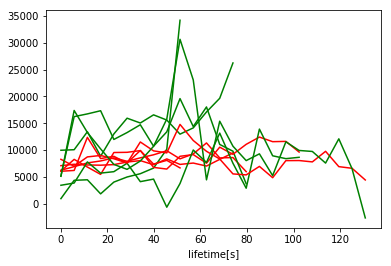

In [137]:
for tc in range(1,len(lifetimeCohorts)):

    m_buffer = []
    s_buffer = []
    bufferSize = 1000
    for i in range(0,bufferSize):
        m_buffer.append([])
        s_buffer.append([])
    
        
    for trackId in lifetimeCohorts[tc]:
        #print(trackId)
        track = data[data['trackId'] == trackId]
    
        m_intensity = track['m_A'].values.astype(float)
        s_intensity = track['s_A'].values.astype(float)
        
        #plt.plot(s_intensity)
        
        for i in range(0,len(track)):
            m_buffer[i].append(m_intensity[i])
            s_buffer[i].append(s_intensity[i])
            
    
    m_mean = []
    s_mean = []
    for i in range(0,bufferSize):
        m_mean.append(np.nanmean(m_buffer[i]))
        s_mean.append(np.nanmean(s_buffer[i]))
        
    plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,m_mean, c='red')
    plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,s_mean, c='green')

plt.xlabel('lifetime[s]')
plt.show()


509
50
7
10 51


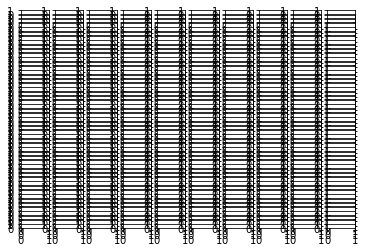

In [144]:
print(len(cat_Ia_Tracks))
print(507//10)
print(507%10)
nrows = 10
ncols = (len(dataBasis)//nrows)+1
print(nrows,ncols)
f, axarr = plt.subplots(ncols, nrows)
for i in range(0,ncols):
    for j in range(0,nrows):
        axarr[i, j].plot(x, y)


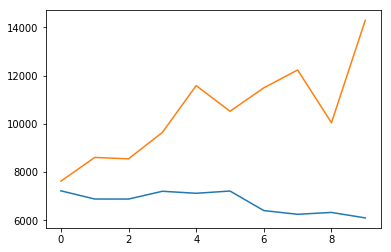

7


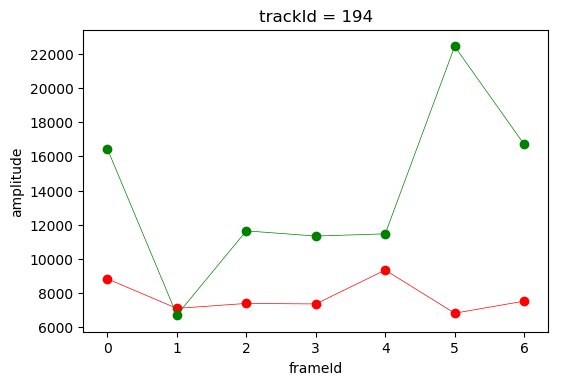

In [81]:
trackSelectionId = 103
trackSelection = cat_Ia_Tracks

trackId = lifetimeCohorts[0][1]
track = data[data['trackId'] == trackId]
plt.figure(dpi=100)
ax = plt.axes()

# Data for a three-dimensional line
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_intensity = track['m_A'].values.astype(float)

s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_intensity = track['s_A'].values.astype(float)

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.plot(m_intensity,c='red',lw=0.5)
ax.scatter(range(0,len(m_intensity)),m_intensity,c='red')
ax.plot(s_intensity,c='green',lw=0.5)
ax.scatter(range(0,len(s_intensity)),s_intensity,c='green')
plt.title('trackId = '+str(trackId))
plt.xlabel('frameId')
plt.ylabel('amplitude')


print(len(track))